# Traiter plus de données

Le notebook d'example n'utilisait que les 10000 premiers événements d'un fichier de données. Vous verrez qu'il ne s'agit que d'une petite fraction des données. Pour mettre au point vos différents code une telle fraction sera sans doute suffisante (et permet de faire des "explorations" rapides des données), mais tôt ou tard il vous faudra passer sur plus de données. 

Pour ce faire il faut être capable de boucler sur les données. Etre capable de le faire rapidement est un bonus appréciable.

## Traitement par lots

Pour "boucler" on travaille "par lot" grâce à la fonction `iterate` de `uproot`. 

> "boucler" est entre guillements car vous verrez que l'analyse en python est efficace si l'on utilise ce que l'on appelle le "array programming", c'est-à-dire qu'il faut prendre l'habitude de travailler sur des tableaux plutôt que sur des valeurs uniques (ce que l'on appelle également _vectoriser_).

Comme dans le notebook d'example, nous analysons un fichier de données récupéré sur Cernbox 

In [1]:
import uproot
import awkward as ak
import numpy as np
import math
import hist

In [4]:
!curl "https://cernbox.cern.ch/index.php/s/r7VFXonK39smzKP/download?path=290223/AnalysisResults.root" > run290223.data.root


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:04 --:--:--     0
  0 3602k    0 11841    0     0   2368      0  0:25:57  0:00:05  0:25:52  2165
 80 3602k   80 2891k    0     0   481k      0  0:00:07  0:00:06  0:00:01  456k
100 3602k  100 3602k    0     0   600k      0  0:00:06  0:00:06 --:--:--  554k


In [5]:
file = uproot.open("run290223.data.root")
events = file["eventsTree"]

Au contraire du notebook d'exemple, nous allons cette fois-ci analyser _toutes_ les données de ce fichier, mais par lot (de 10000 événements = `step_size`) grâce à la fonction `iterate` de `uproot` :

In [6]:
for m in events.iterate(["nMuons","Muon_Px","Muon_Py","Muon_Pz","Muon_Charge"],how="zip",step_size=10000):
    print(len(m),len(m[ak.where(m.nMuons>1)]))

10000 90
10000 94
10000 84
10000 86
10000 81
10000 100
10000 71
7444 69


On définit comme précédemment quelques fonctions pour calculer la pseudo-rapidité :

In [9]:
def mag(px:float,py:float,pz:float):
    """Returns the norm of the 3-vector (px,py,pz)."""
    return math.sqrt(px*px+py*py+pz*pz)

def costheta(px:float,py:float,pz:float):
    """Returns the cos(theta) of the 3 vector (px,py,pz)."""
    ptot = mag(px,py,pz)
    return 1.0 if ptot == 0.0 else pz/ptot

def eta(px:float,py:float,pz:float):
    """Returns the pseudo-rapidity of the 3 vector (px,py,pz)."""
    ct = costheta(px,py,pz)
    if ct*ct < 1:
        return -0.5* math.log( (1.0-ct)/(1.0+ct) )
    if pz == 0: 
        return 0
    if pz>0: 
        return 10E10
    else:
        return -10E20

Au lieu de créer un tableau unique de grande taille avec toutes les valeurs de $\eta$ (comme on l'a fait ci-dessus) _puis_ de faire un histogramme de ces valeurs, on peut créer _d'abord_ un histogramme puis le remplir au fur et à mesure du traitement par lot.

In [7]:
import hist
hEta = hist.Hist(hist.axis.Regular(bins=100,start=-6,stop=0,name='$\eta$'))

In [10]:
nofTracks=0 
nofEvents=0  
for m in events.iterate(["nMuons","Muon_Px","Muon_Py","Muon_Pz","Muon_Charge"],how="zip",step_size=10000):
    for event in m[m.nMuons>0]:
        nofEvents+=1
        tracks = event["Muon"].to_list()
        for t in tracks:
            nofTracks+=1
            hEta.fill(eta(t["Px"],t["Py"],t["Pz"]))
print(nofEvents,nofTracks)

12907 13621


Le module `hist` offre une fonction `plot` qui permet de visualiser rapidement l'histogramme : 

In [11]:
hEta.plot();

Hist requires mplhep to plot, either install hist[plot] or mplhep


ModuleNotFoundError: No module named 'mplhep'

Et en utilisant `matplotlib` on peut configurer ce plot : 

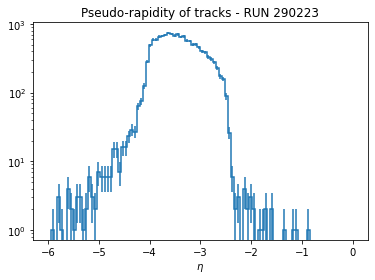

In [207]:
import matplotlib.pyplot as plt
hEta.plot()
plt.yscale("log")
plt.title('Pseudo-rapidity of tracks - RUN 290223');

## Vectorisation

> Cette partie n'est pas indispensable au bon déroulement du projet mais permet d'accéler les calculs et de commencer à vous familiariser avec une façon d'organiser les calculs habituelle dans le monde "data science / deep learning".

Si l'on reprend l'iteration sur les données on note qu'elle n'est pas particulièrement rapide :  

In [208]:
%%time
for m in events.iterate(["nMuons","Muon_Px","Muon_Py","Muon_Pz","Muon_Charge"],how="zip",step_size=10000):
    for event in m[m.nMuons>0]:
        tracks = event["Muon"].to_list()
        for t in tracks:
            e = eta(t["Px"],t["Py"],t["Pz"])

CPU times: user 1.63 s, sys: 5.48 ms, total: 1.64 s
Wall time: 1.64 s


Ceci est dû au fait que l'on calcule la pseudo-rapidité trace par trace (dans la fonction `Eta`) au lieu de faire des calculs sur des tableaux entiers. Essayons d'améliorer cela en commençant par le calcul de la norme de l'impulsion.

In [209]:
%%time
for m in events.iterate(["nMuons","Muon_Px","Muon_Py","Muon_Pz","Muon_Charge"],how="zip",step_size=10000):
    for event in m[m.nMuons>0]:
        tracks = event["Muon"].to_list()
        for t in tracks:
            e = mag(t["Px"],t["Py"],t["Pz"])

CPU times: user 1.62 s, sys: 6.12 ms, total: 1.62 s
Wall time: 1.62 s


On va remplacer le calcul sur un groupe de trois scalaires (px,py,pz) par un calcul sur trois vecteurs (px,py,pz) à l'aide de fonctions du module `numpy` (préfixées par `np.`) :

In [15]:
def vmag(px,py,pz):
    """Returns an array of the norms of the 3-vectors (px,py,pz)."""
    return np.sqrt(px*px+py*py+pz*pz)

In [211]:
%%time
for m in events.iterate(["nMuons","Muon_Px","Muon_Py","Muon_Pz","Muon_Charge"],step_size=10000):
    atLeastOneMuon = m.nMuons>0
    t = m[atLeastOneMuon]
    mag = vmag(t["Muon_Px"],t["Muon_Py"],t["Muon_Pz"])

CPU times: user 122 ms, sys: 2.95 ms, total: 125 ms
Wall time: 124 ms


Vous noterez que c'est bien plus rapide que la boucle initiale. Etendons cela au calcul de $\eta$ :

In [12]:
def vcostheta(px,py,pz):
    """Returns an array of cos(theta) for the 3 vectors (px,py,pz)."""
    ptot = vmag(px,py,pz);
    return np.divide(pz,ptot)

def veta(px:float,py:float,pz:float):
    """Returns the pseudo-rapidity of the 3 vector (px,py,pz)."""
    ct = vcostheta(px,py,pz)
    return -0.5* np.log( (1.0-ct)/(1.0+ct) )

In [13]:
vhEta = hist.Hist(hist.axis.Regular(bins=100,start=-6,stop=0,name='$\eta$'))

In [16]:
%%time
for m in events.iterate(["nMuons","Muon_Px","Muon_Py","Muon_Pz","Muon_Charge"],step_size=10000):
    atLeastOneMuon = m.nMuons>0
    t = m[atLeastOneMuon]
    eta = veta(t["Muon_Px"],t["Muon_Py"],t["Muon_Pz"])
    vhEta.fill(ak.flatten(eta))

Wall time: 2.94 s


In [20]:
vhEta.plot();

AttributeError: module 'matplotlib.cbook' has no attribute '_make_class_factory'